# MNIST experiment

In [1]:
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from synthetic_data import  DatasetFromList

from models import Linear
from loss import hinge_loss01, OAT_loss

from tqdm import tqdm
from plot_utils import Eval
import matplotlib.pyplot as plt
import pandas as pd
import os

/Users/rpukdee/opt/anaconda3/envs/adv_train2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class BinaryMNIST(Dataset):
    def __init__(self, train):
        if train:
            batch_size = 50000
            data_size = 4000
            # batch_size = 500
            # data_size = 40
        else:
            batch_size = 10000
            data_size = 750
            # batch_size = 1000
            # data_size = 75

        original_train_loader = torch.utils.data.DataLoader(
                                    datasets.MNIST('./data/', train=train, download=True,
                                    transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))])),
                                    batch_size=batch_size, shuffle=False)
        train_data = next(iter(original_train_loader))
        data = train_data[0].squeeze()
        targets = train_data[1]

        idx0 = (targets == 0)
        idx1 = (targets == 1)
        self.x = torch.cat(((data[idx0])[:data_size,:,:],(data[idx1])[:data_size,:,:]))
        self.y = torch.cat(((targets[idx0])[:data_size],(targets[idx1])[:data_size]))
        self.n_samples = 2*data_size

    def __getitem__(self, index):
        return (self.x[index]).reshape(-1).float(), self.y[index]
    
    def __len__(self):
        return self.n_samples

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def train(model, train_loader, loss, optimizer, num_epochs):
    for _ in range(num_epochs):
        for _, (X,y) in enumerate(train_loader):
            X,y = X.to(device), y.to(device)
            pre = model(X).flatten()
            cost = loss(pre, y.flatten())

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()


def AT_SVM(name, model, num_epochs, train_data, eps, batch_size1, batch_size2 = 100, num_grad_step = 5, lr = 0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = 0.01)
    train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                            batch_size=batch_size1,
                                            shuffle=False)
    for epoch in tqdm(range(num_epochs)):
        for _, (X,y) in enumerate(train_loader):
            # Generate adversarial example
            N = X.shape[0]
            d = X.reshape(N,-1).shape[1]
            weight = model.state_dict()['linear.0.weight'] 
            sign = 1*(weight > 0) - 1*(weight < 0)
            delta = eps* sign.repeat(N,1) * (y.repeat(d, 1).transpose(1,0)*2 - 1)
            X_adv = (X - delta).detach()

            # Train model
            dataset_i = DatasetFromList([X_adv],[y])
            train_loader_i = torch.utils.data.DataLoader(dataset=dataset_i,
                                                    batch_size=batch_size2,
                                                    shuffle=True)
            
            train(model, train_loader_i, hinge_loss01, optimizer, num_epochs = num_grad_step)

        torch.save(model.state_dict(), 'checkpoint/'+ name + '_epoch_'+ str(epoch))


    
def oat_train(model, train_loader, optimizer, num_epochs, eps):
    for _ in range(num_epochs):
        for _, (X,y) in enumerate(train_loader):
            X,y = X.to(device), y.to(device)
            cost = OAT_loss(model, X, y.flatten(), eps)

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

def OAT_SVM(name, model, num_epochs, train_data, eps, batch_size1, batch_size2 = 100, num_grad_step = 5, lr = 0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = 0.01)
    train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                            batch_size=batch_size2,
                                            shuffle=False)
    for epoch in tqdm(range(num_epochs)):
        oat_train(model, train_loader, optimizer, num_epochs= num_grad_step, eps = eps)
        torch.save(model.state_dict(), 'checkpoint/'+ name + '_epoch_'+ str(epoch))

In [5]:
# load data
train_data = BinaryMNIST(train = True)
test_data = BinaryMNIST(train = False)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                            batch_size=128,
                                            shuffle=False)

try:
    print('--- Creating a directory ---')
    os.mkdir('checkpoint')
except:
    print('--- The directory exists ---')


# hyperparameter
lr = 0.01
num_grad_step = 5 
batch_size = 8000
repeat = 5 #number of runs

acc_results = []
robust_acc_results = []
weight_diff_results = []



for eps_unnorm in [8,16,32,48,64,80,96,112,128]:
    eps = eps_unnorm/(255*0.3081)
    for _ in range(repeat):
        # Aversarial training
        model = Linear(in_feature = 28*28, out_feature = 1)
        AT_SVM('MNIST_AT', model, 50, train_data, eps = eps, batch_size1 = batch_size, 
        batch_size2 = batch_size, num_grad_step = num_grad_step, lr = lr)
        result_AT = Eval('MNIST_AT', 50, Linear(in_feature= 28*28, out_feature = 1), test_loader, eps = eps)

        acc_results.append(([eps_unnorm,num_grad_step, 'AT'])+ result_AT['Standard acc'])
        robust_acc_results.append(([eps_unnorm,num_grad_step, 'AT']) + result_AT['Robust acc'])
        weight_diff_results.append(([eps_unnorm,num_grad_step, 'AT']) + result_AT['Weight diff'])

        # Optimal Adversarial training
        model = Linear(in_feature = 28*28, out_feature = 1)
        OAT_SVM('MNIST_OAT', model, 50, train_data, eps = eps, batch_size1 = batch_size, 
        batch_size2 = batch_size, num_grad_step = num_grad_step, lr = lr)
        result_OAT = Eval('MNIST_OAT', 50, Linear(in_feature= 28*28, out_feature = 1), test_loader, eps = eps)

        acc_results.append(([eps_unnorm,num_grad_step, 'OAT'])+ result_OAT['Standard acc'])
        robust_acc_results.append(([eps_unnorm,num_grad_step, 'OAT'])+ result_OAT['Robust acc'])
        weight_diff_results.append(([eps_unnorm,num_grad_step, 'OAT'])+ result_OAT['Weight diff'])

--- Creating a directory ---
--- The directory exists ---


100%|██████████| 50/50 [00:00<00:00, 175.11it/s]


In [6]:
# create a dataframe
column_name = ['eps','gradient update','method'] + [i for i in range(len(result_OAT['Robust acc']))]
rob_acc_df = pd.DataFrame(robust_acc_results, columns = column_name)
column_name = ['eps','gradient update','method'] + [i for i in range(len(result_OAT['Weight diff']))]
weight_diff_df = pd.DataFrame(weight_diff_results, columns = column_name)

## Robust Accuracy

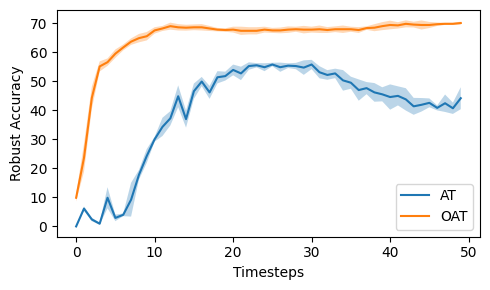

In [7]:
plt.figure(figsize = (5,3), dpi = 100)
eps_unnorm = 64
for method in ['AT','OAT']:
    mean = rob_acc_df[(rob_acc_df['method'] == method)*(rob_acc_df['eps'] == eps_unnorm)].iloc[:,3:].mean()
    std=  rob_acc_df[(rob_acc_df['method'] == method)*(rob_acc_df['eps'] == eps_unnorm)].iloc[:,3:].std()
    x = range(len(mean))
    plt.plot(x, mean, label = method)
    plt.fill_between(x, mean - std, mean + std, alpha = 0.3, label= None)

plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Robust Accuracy')
plt.tight_layout()
# plt.savefig('robust_acc.pdf')


## Convergence

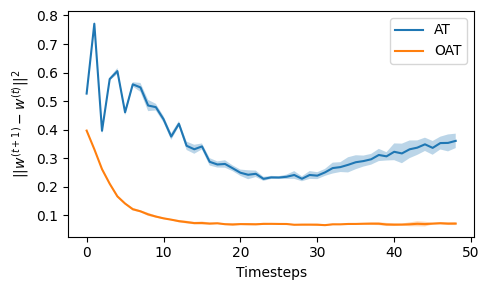

In [8]:
plt.figure(figsize = (5,3), dpi = 100)
eps_unnorm = 64
for method in ['AT','OAT']:
    mean = weight_diff_df[(weight_diff_df['method'] == method)*(weight_diff_df['eps'] == eps_unnorm)].iloc[:,3:].mean()
    std=  weight_diff_df[(weight_diff_df['method'] == method)*(weight_diff_df['eps'] == eps_unnorm)].iloc[:,3:].std()
    x = range(len(mean))
    plt.plot(x, mean, label = method)
    plt.fill_between(x, mean - std, mean + std, alpha = 0.3, label= None)

plt.legend()

plt.ylabel(r'$||w^{(t+1)} - w^{(t)}||^2$')
plt.xlabel('Timesteps')

plt.tight_layout()
# plt.savefig('weight_diff.pdf')

## Ablation: Perturbation budget

In [9]:
df3 = pd.DataFrame(rob_acc_df.groupby(['eps','method']).mean().iloc[:,-1]).unstack()
df4 = pd.DataFrame(rob_acc_df.groupby(['eps','method']).std().iloc[:,-1]).unstack()

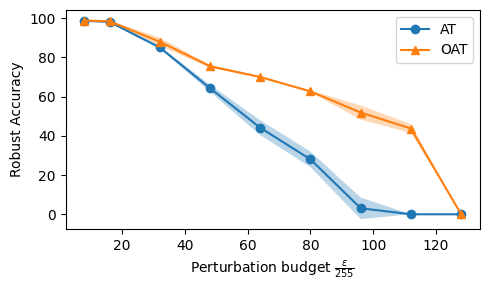

In [10]:
plt.figure(figsize = (5,3), dpi = 100)
eps_unnorm = 64
method_list = ['AT','OAT']
marker = ['o','^']
for i in range(2):
    mean = df3.iloc[:,i]
    std=  df4.iloc[:,i]
    x = df3.index
    plt.plot(x, mean, label = method_list[i], marker = marker[i])
    plt.fill_between(x, mean - std, mean + std, alpha = 0.3, label= None)

plt.legend()

plt.ylabel('Robust Accuracy')
plt.xlabel(r'Perturbation budget $\frac{\varepsilon}{255}$')

plt.tight_layout()
# plt.savefig('vary_epsilon.pdf')

## Ablation: Number of gradient step

In [11]:
# load data
train_data = BinaryMNIST(train = True)
test_data = BinaryMNIST(train = False)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                            batch_size=128,
                                            shuffle=False)

# hyperparameter
lr = 0.01
num_grad_step = 5
batch_size = 8000
repeat = 5
# Adversarial training
acc_results = []
robust_acc_results = []
weight_diff_results = []

for eps_unnorm in [64]:
    for num_grad_step in [1,2,3,4,5,6,7,8,9,10]:
        eps = eps_unnorm/(255*0.3081)
        for _ in range(repeat):
            # Adversarial training
            model = Linear(in_feature = 28*28, out_feature = 1)
            AT_SVM('MNIST_AT', model, 50, train_data, eps = eps, batch_size1 = batch_size, 
            batch_size2 = batch_size, num_grad_step = num_grad_step, lr = lr)
            result_AT = Eval('MNIST_AT', 50, Linear(in_feature= 28*28, out_feature = 1), test_loader, eps = eps)

            acc_results.append(([eps_unnorm,num_grad_step, 'AT'])+ result_AT['Standard acc'])
            robust_acc_results.append(([eps_unnorm,num_grad_step, 'AT']) + result_AT['Robust acc'])
            weight_diff_results.append(([eps_unnorm,num_grad_step, 'AT']) + result_AT['Weight diff'])

            # Optimal Adversarial training
            model = Linear(in_feature = 28*28, out_feature = 1)
            OAT_SVM('MNIST_OAT', model, 50, train_data, eps = eps, batch_size1 = batch_size, 
            batch_size2 = batch_size, num_grad_step = num_grad_step, lr = lr)
            result_OAT = Eval('MNIST_OAT', 50, Linear(in_feature= 28*28, out_feature = 1), test_loader, eps = eps)

            acc_results.append(([eps_unnorm,num_grad_step, 'OAT'])+ result_OAT['Standard acc'])
            robust_acc_results.append(([eps_unnorm,num_grad_step, 'OAT'])+ result_OAT['Robust acc'])
            weight_diff_results.append(([eps_unnorm,num_grad_step, 'OAT'])+ result_OAT['Weight diff'])

100%|██████████| 50/50 [00:00<00:00, 86.50it/s]


In [12]:
# create a dataframe
column_name = ['eps','gradient update','method'] + [i for i in range(len(result_OAT['Robust acc']))]
rob_acc_df = pd.DataFrame(robust_acc_results, columns = column_name)
column_name = ['eps','gradient update','method'] + [i for i in range(len(result_OAT['Weight diff']))]
weight_diff_df = pd.DataFrame(weight_diff_results, columns = column_name)

In [13]:
df3 = rob_acc_df.groupby(['gradient update', 'method']).mean().iloc[:,-1].unstack()
df4 = rob_acc_df.groupby(['gradient update', 'method']).std().iloc[:,-1].unstack()

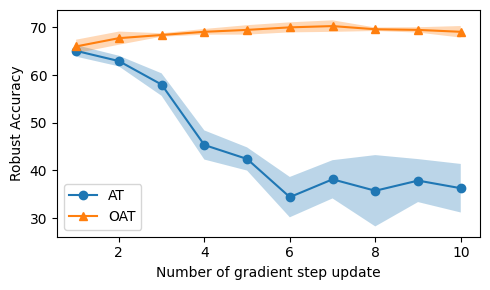

In [14]:
plt.figure(figsize = (5,3), dpi = 100)
eps_unnorm = 64
method_list = ['AT','OAT']
marker = ['o','^']
for i in range(2):
    mean = df3.iloc[:,i]
    std=  df4.iloc[:,i]
    x = df3.index
    plt.plot(x, mean, label = method_list[i], marker = marker[i])
    plt.fill_between(x, mean - std, mean + std, alpha = 0.3, label= None)

plt.legend()

plt.ylabel('Robust Accuracy')
plt.xlabel(r'Number of gradient step update')

plt.tight_layout()
# plt.savefig('vary_num_grad_step.pdf')